In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d

ann_arr = load_model('IP_Arrival_time/Arrival_ANN_1')
ann_end = load_model('IP_End_time/End_ANN_2')
ann_chg = load_model('IP_Change_time/Change_ANN_3')

#Section1
ann1 = load_model('IP_Section_1_new/Section1_ANN_3')
sc1 = pickle.load(open('IP_Section_1_new/Section1_scaler_ANN_3.pkl', 'rb'))
#Section2
ann2 = load_model('IP_Section_2_new/Section2_new_ANN_5')
sc2 = pickle.load(open('IP_Section_2_new/Section2_new_scaler_ANN_5.pkl', 'rb'))
#Section3
ann3 = load_model('IP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('IP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('IP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('IP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('IP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('IP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('IP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('IP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at you

In [5]:
# Mapping logic based on Section
def get_scaler_and_model(section):
    sc = scalers.get(section)
    ann = models.get(section)

    if sc is None or ann is None:
        raise ValueError(f"Invalid Section: {section}. Valid sections are 1 to 6.")

    return sc, ann

def stable_state(start, end, interval):    
        t = np.arange(start, end + interval, interval)
        t = t.reshape(len(t),1)
    
        p = np.repeat(0, len(t)).reshape(len(t),1)
        
        values = np.concatenate ((t, p), axis = 1)
        return values
    
def p_fluctuation(d_set, sc, ann):
    d_set[:,0:3] = sc.transform(d_set[:,0:3])
    p_f = ann.predict(d_set)
    return p_f

# Define the function to generate time_ann and y_ann
def ann_prediction(Distance, Mass, termination_time, sc, ann, interval=0.01):

    arr = np.array ([[Mass,Distance]])
    arrival_time = ann_arr.predict(arr)
    end_time = ann_end.predict(arr)
    change_time = ann_chg.predict(arr)
    
    print ("arrival", arrival_time, "end", end_time, "change", change_time)
    
    if termination_time < end_time:
        end_time = termination_time
        print (end_time)
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)
        print (values3)
    
    t2= np.arange(arrival_time, end_time + interval, interval)
    t2 = t2.reshape(len(t2),1)
    
    if t2[0] < change_time:
        ph2 = np.array([[0, 1]])
    else:
        ph2 = np.array([[1, 0]])
        
    positive = np.array([0, 1])
    negative= np.array([1, 0])
    
    for time in t2[1:]:
        if time < change_time:
            ph2=np.vstack((ph2,positive))
        else:
            ph2=np.vstack((ph2,negative))
            
    m2 = np.repeat(Mass, len(t2)).reshape(len(t2),1)
    d2 = np.repeat(Distance, len(t2)).reshape(len(t2),1)
    d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)
    
    p2 = p_fluctuation(d_set, sc, ann)
    p2 = p2.reshape((-1, 1))
    values2 = np.concatenate ((t2, p2), axis = 1)
    
    if 'values3' in locals():
        ml_model = np.concatenate((values2, values3), axis=0)
        print ('if')
    else:
        ml_model = values2
        print('else')
        
    time = ml_model[:,0]
    y = ml_model[:,1]+101.25
    
    return time, y


Final Integration Value Numerical: 3420.66
1/1 [==============================] - 0s 42ms/step
arrival [[61.101578]] end [[94.10556]] change [[68.70878]]
94.03992444299999
103/103 [==============================] - 0s 2ms/step
else
Final Integration Value ANN: 3340.24


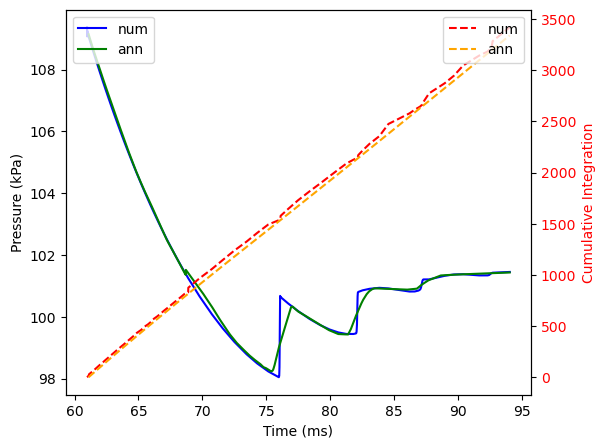

In [6]:
# Define the root directory
file_path = Path('G:/Chamodi/LSDYNA_1D/Incident_pressure_time_history/Far_field_time_history_dataset/L13_17/P49.xlsx')
Section = 6

#distance_mapping = {'5': 1.5, '7': 1.75, '9': 2, '11': 2.25, '13': 2.5, '15': 2.75, '17': 3}
scalers = {1: sc1, 2: sc2, 3: sc3, 4: sc4, 5: sc5, 6: sc6}
models = {1: ann1, 2: ann2, 3: ann3, 4: ann4, 5: ann5, 6: ann6}
sc, ann = get_scaler_and_model(Section)

# Extract the parent directory name
parent_dir = file_path.parent.name

# Parse distance and mass from the directory name
_, rest = parent_dir.split('_', 1)
mass = int(rest) / 2

# Extract the file name without extension and map to angle
file_name = file_path.stem[1:]
distance = np.ceil(int(file_name)/2)
#distance = distance_mapping.get(file_name, None)  # Use None if file name is not in the mapping

df = pd.read_excel(file_path)

# Filter the DataFrame to keep only rows with matching Mass and Distance
df_filtered = df[(df['Mass'] == mass) & (df['Standoff distance'] == distance)]

# If the filtered DataFrame is empty, raise an error or return a default value
if df_filtered.empty:
    raise ValueError(f"No rows found matching the specified Mass {mass}, Distance {distance}.")

# Sort the filtered DataFrame by Time in ascending order
df_sorted = df_filtered.sort_values(by='Time', ascending=True)

# Extract time and pressure values
time_num = df_sorted['Time'].values
y_num = df_sorted['Pressure'].values+101.25

termination_time = np.max(time_num)

## Numerical
# Perform cumulative integration using the trapezoidal rule
cumulative_integration_num = np.cumsum(np.gradient(time_num) * y_num)

# Get the final integration value
final_integration_value_num = cumulative_integration_num[-1]

# Print the final integration value
print(f"Final Integration Value Numerical: {final_integration_value_num:.2f}")

## ANN
time_ann, y_ann = ann_prediction(distance, mass, termination_time, sc, ann, interval=0.01)

# Perform cumulative integration using the trapezoidal rule
cumulative_integration_ann = np.cumsum(np.gradient(time_ann) * y_ann)

# Get the final integration value
final_integration_value_ann = cumulative_integration_ann[-1]

# Print the final integration value
print(f"Final Integration Value ANN: {final_integration_value_ann:.2f}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plot the original data (y vs time) on the primary y-axis
ax1.plot(time_num, y_num, label='num', color='blue')
ax1.plot(time_ann, y_ann, label='ann', color='green')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Pressure (kPa)')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the cumulative integration
ax2 = ax1.twinx()
ax2.plot(time_num, cumulative_integration_num, linestyle='--', label='num', color='red')
ax2.plot(time_ann, cumulative_integration_ann, linestyle='--', label='ann', color='orange')
ax2.set_ylabel('Cumulative Integration', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
plt.show()